In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Don't forget to use `ml_env` environment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector


In [2]:
pd.set_option('display.max_columns', 50)

def clear_cols(s):
    return s.strip().replace(" ","_")

In [3]:
inpatient_path   = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Inpatientdata-1542865627584.csv'
outpatient_path  = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Outpatientdata-1542865627584.csv'
train_path       = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train-1542865627584.csv'
beneficiary_path = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Beneficiarydata-1542865627584.csv'

# read inpatient outpatient and train files data
inpatient  = pd.read_csv(inpatient_path).rename(columns=clear_cols)
outpatient = pd.read_csv(outpatient_path).rename(columns=clear_cols)
train      = pd.read_csv(train_path).rename(columns=clear_cols)
bene       = pd.read_csv(beneficiary_path).rename(columns=clear_cols)

In [4]:
train.sample()

,Provider,PotentialFraud
4754,PRV56956,No


In [5]:
inpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
2958,BENE21701,CLM50731,2009-05-11,2009-05-14,PRV56630,3000,PHY411239,PHY411239,NaN,2009-05-11,92411,1068.0,2009-05-14,575,92401,30002,V5866,V1085,7960,3310,4263,V1588,40390,4280,8659.0,NaN,NaN,NaN,NaN,NaN


In [6]:
inpatient['Provider'].nunique()

2092

In [7]:
df = inpatient.groupby('Provider').agg(
    IPTotalInscClaimAmtReimbursed = ('InscClaimAmtReimbursed', 'sum'),
    IPMeanInscClaimAmtReimbursed = ('InscClaimAmtReimbursed', 'mean')
)

In [8]:
df

,IPTotalInscClaimAmtReimbursed,IPMeanInscClaimAmtReimbursed
Provider,,
PRV51001,97000,19400.000000
PRV51003,573000,9241.935484
PRV51007,19000,6333.333333
PRV51008,25000,12500.000000
PRV51011,5000,5000.000000
...,...,...
PRV57719,76000,19000.000000
PRV57728,6000,6000.000000
PRV57729,107000,9727.272727


In [9]:
outpatient['Provider'].nunique()

5012

In [10]:
out_df = outpatient.groupby('Provider').agg(
    OPTotalInscClaimAmtReimbursed = ('InscClaimAmtReimbursed', 'sum'),
    OPMeanInscClaimAmtReimbursed = ('InscClaimAmtReimbursed', 'mean')
)
out_df

,OPTotalInscClaimAmtReimbursed,OPMeanInscClaimAmtReimbursed
Provider,,
PRV51001,7640,382.000000
PRV51003,32670,466.714286
PRV51004,52170,350.134228
PRV51005,280910,241.124464
PRV51007,14710,213.188406
...,...,...
PRV57759,10640,380.000000
PRV57760,4770,216.818182
PRV57761,18470,225.243902


In [11]:
# Merge IP and OP provider totals
provider_claims = pd.merge(
    df,  # Left: Provider, IP_Claims_Total
    out_df,  # Right: Provider, OP_Claims_Total
    on='Provider',
    how='outer'
).reset_index().fillna(0)  # Fill NaN with 0 for providers with only one type of claims

In [12]:
provider_claims

,Provider,IPTotalInscClaimAmtReimbursed,IPMeanInscClaimAmtReimbursed,OPTotalInscClaimAmtReimbursed,OPMeanInscClaimAmtReimbursed
0,PRV51001,97000.0,19400.000000,7640.0,382.000000
1,PRV51003,573000.0,9241.935484,32670.0,466.714286
2,PRV51004,0.0,0.000000,52170.0,350.134228
3,PRV51005,0.0,0.000000,280910.0,241.124464
4,PRV51007,19000.0,6333.333333,14710.0,213.188406
...,...,...,...,...,...
5405,PRV57759,0.0,0.000000,10640.0,380.000000
5406,PRV57760,0.0,0.000000,4770.0,216.818182
5407,PRV57761,0.0,0.000000,18470.0,225.243902
5408,PRV57762,0.0,0.000000,1900.0,1900.000000


In [13]:
# # Save selected columns to CSV
# provider_claims.to_csv('2 draft.csv', index=False)

In [14]:
provider_claims['IPTotalInscClaimAmtReimbursed'].sum()

np.float64(408297020.0)

In [15]:
provider_claims['OPTotalInscClaimAmtReimbursed'].sum()

np.float64(148246120.0)

In [16]:
# Then merge with fraud labels
final_df = pd.merge(
    provider_claims,
    train[['Provider', 'PotentialFraud']],
    on='Provider',
    how='outer'
)

In [17]:
final_df

,Provider,IPTotalInscClaimAmtReimbursed,IPMeanInscClaimAmtReimbursed,OPTotalInscClaimAmtReimbursed,OPMeanInscClaimAmtReimbursed,PotentialFraud
0,PRV51001,97000.0,19400.000000,7640.0,382.000000,No
1,PRV51003,573000.0,9241.935484,32670.0,466.714286,Yes
2,PRV51004,0.0,0.000000,52170.0,350.134228,No
3,PRV51005,0.0,0.000000,280910.0,241.124464,Yes
4,PRV51007,19000.0,6333.333333,14710.0,213.188406,No
...,...,...,...,...,...,...
5405,PRV57759,0.0,0.000000,10640.0,380.000000,No
5406,PRV57760,0.0,0.000000,4770.0,216.818182,No
5407,PRV57761,0.0,0.000000,18470.0,225.243902,No
5408,PRV57762,0.0,0.000000,1900.0,1900.000000,No


In [18]:
final_df['PotentialFraud'] = final_df['PotentialFraud'].map({'Yes': 1, 'No': 0})
final_df

,Provider,IPTotalInscClaimAmtReimbursed,IPMeanInscClaimAmtReimbursed,OPTotalInscClaimAmtReimbursed,OPMeanInscClaimAmtReimbursed,PotentialFraud
0,PRV51001,97000.0,19400.000000,7640.0,382.000000,0
1,PRV51003,573000.0,9241.935484,32670.0,466.714286,1
2,PRV51004,0.0,0.000000,52170.0,350.134228,0
3,PRV51005,0.0,0.000000,280910.0,241.124464,1
4,PRV51007,19000.0,6333.333333,14710.0,213.188406,0
...,...,...,...,...,...,...
5405,PRV57759,0.0,0.000000,10640.0,380.000000,0
5406,PRV57760,0.0,0.000000,4770.0,216.818182,0
5407,PRV57761,0.0,0.000000,18470.0,225.243902,0
5408,PRV57762,0.0,0.000000,1900.0,1900.000000,0


# Modeling part

In [19]:
X = final_df[[
      'IPTotalInscClaimAmtReimbursed',
      'IPMeanInscClaimAmtReimbursed',
      'OPTotalInscClaimAmtReimbursed',
      'OPMeanInscClaimAmtReimbursed']]

In [20]:
y = final_df['PotentialFraud']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [22]:
# I have 80% of the data here, without the potential fraud column
X_train

,IPTotalInscClaimAmtReimbursed,IPMeanInscClaimAmtReimbursed,OPTotalInscClaimAmtReimbursed,OPMeanInscClaimAmtReimbursed
3682,0.0,0.000000,800.0,800.000000
1323,50000.0,7142.857143,21070.0,309.852941
1583,0.0,0.000000,3520.0,251.428571
4318,0.0,0.000000,9600.0,204.255319
2876,0.0,0.000000,7280.0,242.666667
...,...,...,...,...
3772,0.0,0.000000,12550.0,404.838710
5191,387000.0,10459.459459,13530.0,178.026316
5226,0.0,0.000000,5330.0,144.054054
5390,0.0,0.000000,2290.0,152.666667


In [23]:
# I have 20% of the data here, without the potential fraud column
X_test

,IPTotalInscClaimAmtReimbursed,IPMeanInscClaimAmtReimbursed,OPTotalInscClaimAmtReimbursed,OPMeanInscClaimAmtReimbursed
290,0.0,0.000000,18340.0,321.754386
1730,0.0,0.000000,710.0,101.428571
4235,0.0,0.000000,1200.0,300.000000
4870,10000.0,10000.000000,4050.0,368.181818
1073,597000.0,11705.882353,55190.0,330.479042
...,...,...,...,...
75,16600.0,5533.333333,0.0,0.000000
1831,40000.0,6666.666667,34780.0,244.929577
2973,0.0,0.000000,660.0,60.000000
3984,0.0,0.000000,126120.0,321.734694


In [24]:
# I have 80% of the potential fraud column, to train the model
y_train

3682    0
1323    0
1583    0
4318    0
2876    0
       ..
3772    0
5191    1
5226    0
5390    0
860     0
Name: PotentialFraud, Length: 4328, dtype: int64

In [25]:
# I have 20% of the potential fraud column, to test the model
y_test

290     0
1730    0
4235    0
4870    0
1073    0
       ..
75      0
1831    0
2973    0
3984    0
3214    0
Name: PotentialFraud, Length: 1082, dtype: int64

In [26]:
# 2. Scale the features (standardization: mean = 0, std = 1).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test = scaler.transform(X_test)  # Transform test data using train's mean & std


In [27]:
# 3. Train a logistic regression model.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Fit model on training data

LogisticRegression(random_state=42)

In [28]:
# 4. Make predictions on the test set.
y_predict = model.predict(X_test)  # Outputs predicted class labels (0 or 1)

y_proba = model.predict_proba(X_test)[:, 1] # predict probabilities, what's closer to 0 or 1.


In [29]:
model.predict_proba(X_test)

array([[0.98158073, 0.01841927],
       [0.98494549, 0.01505451],
       [0.98473092, 0.01526908],
       ...,
       [0.98498132, 0.01501868],
       [0.94171268, 0.05828732],
       [0.95421249, 0.04578751]])

In [30]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix before manipulating by adding the threshold\nConfusion Matrix:")
print(cm)

Confusion Matrix before manipulating by adding the threshold
Confusion Matrix:
[[965  12]
 [ 66  39]]


In [31]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# print('Confusion Matrix before manipulating by adding the threshold:\n')
# Calculating metrics
accuracy = accuracy_score(y_test, y_predict) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.93
Precision: 0.76
Recall: 0.37
F1 Score: 0.50


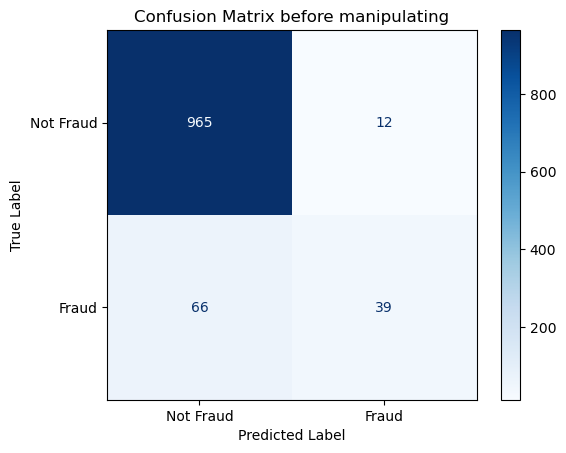

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix before manipulating')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

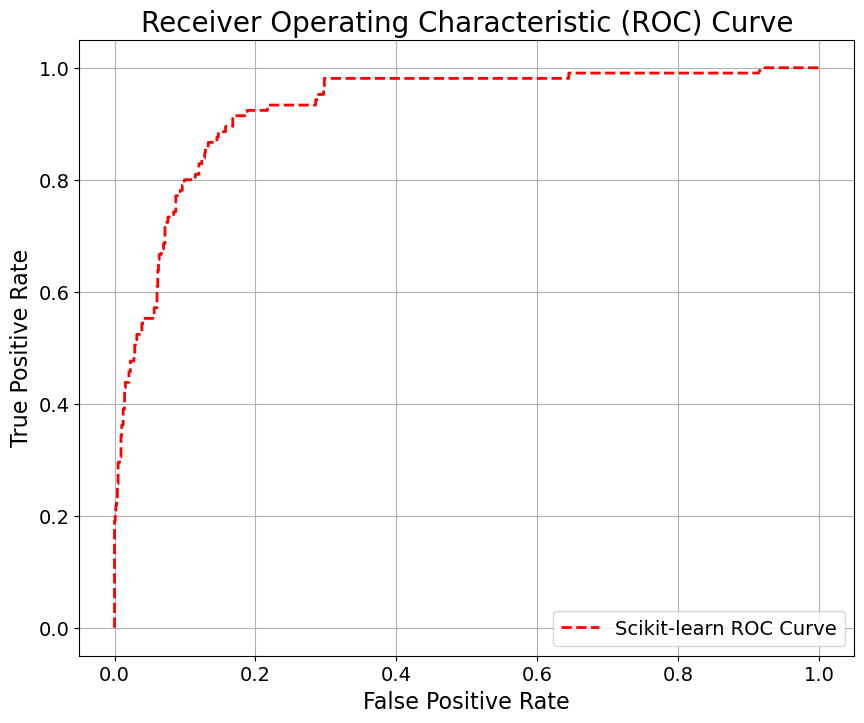

In [33]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [34]:
from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

np.float64(0.9284690744260857)

# Loooking for a better threshold to find the best f1-score:

In [35]:
# # Get predicted probabilities
# y_proba = model.predict_proba(X_test)[:, 1]

In [36]:
# precicions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# f1_scores = 2 * (precicions * recalls) / (precicions + recalls)
# best_threshold = thresholds[f1_scores.argmax()]
# print(f"Optimal threshold based on F1-score: {best_threshold}")

In [37]:
# # apply the new best threshold to the predicted probabilities
# y_pred_custom = (y_proba >= best_threshold).astype(int)
# # Compute confusion matrix
# cm = confusion_matrix(y_test, y_pred_custom)
# print("After proccessing the best threshold for highest F1-score, \nHere is the Confusion Matrix:\n", cm)

In [38]:
# # flatten the confusion matrix and break it down into four components.
# TN, FP, FN, TP = cm.ravel()
# print('Confusion Matrix AFTER manipulating by adding the threshold:\n')
# # Calculating metrics
# accuracy = accuracy_score(y_test, y_pred_custom) # 2 ways to calculate accuracy
# accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
# print(f'Accuracy: {accuracy:.2f}')
# precision = TP / (TP + FP) if (TP + FP) != 0 else 0
# print(f'Precision: {precision:.2f}')
# recall = TP / (TP + FN) if (TP + FN) != 0 else 0
# print(f'Recall: {recall:.2f}')
# f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
# print(f'F1 Score: {f1_score:.2f}')

# Applying Cross Validation

In [39]:
from sklearn.model_selection import cross_val_score

# Define Logistic Regression model
model = LogisticRegression(max_iter=1000)  # Increase max_iter for convergence

# Perform 5-fold cross-validation
# Also looking for the best "roc_auc"
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

# Print cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean roc_auc: {cv_scores.mean():.4f}")


Cross-validation scores: [0.94764889 0.94350077 0.9245264  0.93081923 0.9282413 ]
Mean accuracy: 0.9349


In [40]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support L1 & L2
}

# Define logistic regression model
logreg = LogisticRegression(max_iter=1000)

# Perform GridSearchCV optimizing for roc_auc
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display best parameters and recall score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best roc_auc Score: {grid_search.best_score_:.4f}")


Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best Recall Score: 0.9383


In [41]:
from sklearn.metrics import classification_report

# Get the best trained model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate performance
report = classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud'])
print(report)

              precision    recall  f1-score   support

   Not Fraud       0.93      0.99      0.96       977
       Fraud       0.82      0.30      0.43       105

    accuracy                           0.93      1082
   macro avg       0.87      0.64      0.70      1082
weighted avg       0.92      0.93      0.91      1082



In [ ]:
# #  Grid search for best parameters
# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)


In [43]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer, fbeta_score

# # Define custom scorer (F-beta score with beta=2, which favors recall)
# custom_scorer = make_scorer(fbeta_score, beta=2)

# # Define hyperparameter grid
# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
#     'penalty': ['l1', 'l2'],  # Regularization type
#     'solver': ['liblinear', 'saga']  # Solvers that support L1 & L2
# }

# # Define logistic regression model
# model = LogisticRegression(max_iter=1000)

# # Use GridSearchCV with the custom scorer
# grid_search = GridSearchCV(model, param_grid, cv=5, scoring=custom_scorer, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Print the best parameters & best F-beta score
# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best F2 Score: {grid_search.best_score_:.4f}")


Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Best F2 Score: 0.4844


# Applying SMOTE (Synthetic Minority Over-sampling TEchnique) because our data is very imbalanced (90% not-fraud and 10% is fraud)

In [44]:
from imblearn.over_sampling import SMOTE

# Define features (X) and target (y)
X = final_df.drop(columns=['Provider','PotentialFraud'])
y = final_df['PotentialFraud']

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())


Before SMOTE: PotentialFraud
0    3923
1     405
Name: count, dtype: int64
After SMOTE: PotentialFraud
0    3923
1    3923
Name: count, dtype: int64


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


### After applying it, I have new synthetic data points for the training dataset, so now I can check the model on a balanced dataset to check on a balanced one if the model is good

In [45]:
model_after_smote = LogisticRegression(max_iter=1000)
model_after_smote.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=10000)

In [46]:
# Predict on the test set (original imbalanced data)
y_pred = model_after_smote.predict(X_test)
y_proba = model_after_smote.predict_proba(X_test)[:, 1] # predict probabilities, what's closer to 0 or 1.


## This time I'm checking for the best parameters for RECALL here:

In [47]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga']
}

# Use GridSearchCV to optimize for recall
grid_search = GridSearchCV(model_after_smote, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}


In [48]:
from sklearn.metrics import roc_auc_score

y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score: {auc_score:.4f}")


ROC-AUC Score: 0.9276


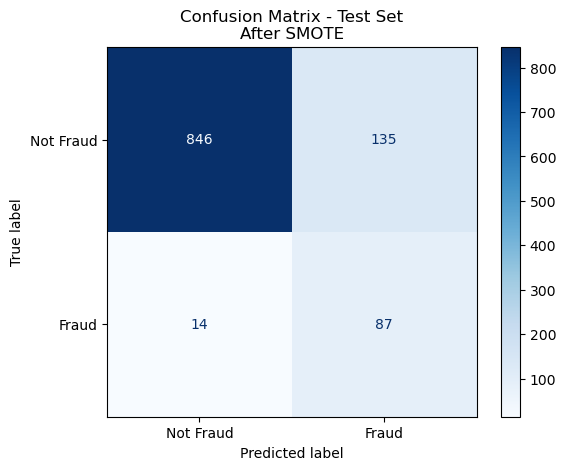

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set\nAfter SMOTE")
plt.show()


In [50]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\nAfter SMOTE:")
print(cm)

Confusion Matrix
After SMOTE:
[[846 135]
 [ 14  87]]


In [51]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('All scores after SMOTE:\n')
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

All scores after SMOTE:

Accuracy: 0.86
Precision: 0.39
Recall: 0.86
F1 Score: 0.54


In [52]:
# from sklearn.metrics import f1_score, fbeta_score

# # Standard F1-score
# f1_score(y_test, y_pred)  

0.5386996904024768

In [53]:
# # F2-score (beta=2 gives more importance to recall)
# fbeta_score(y_test, y_pred, beta=2) 

0.694888178913738

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga']
}

# Use GridSearchCV to optimize for recall
grid_search = GridSearchCV(model_after_smote, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [ ]:
from sklearn.metrics import roc_auc_score

y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score: {auc_score:.4f}")


ROC-AUC Score: 0.9536


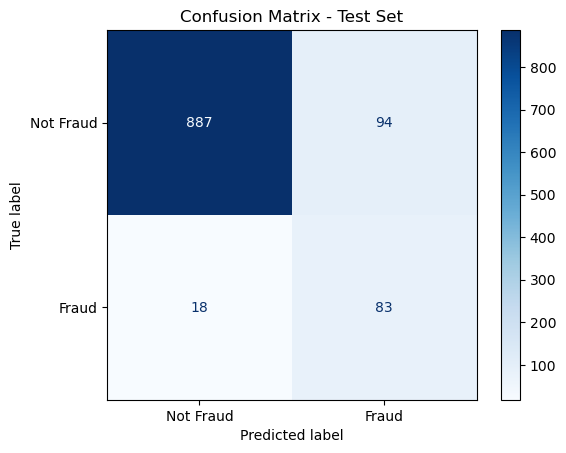

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[887  94]
 [ 18  83]]


In [ ]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('Confusion Matrix before manipulating by adding the threshold:\n')
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Confusion Matrix before manipulating by adding the threshold:

Accuracy: 0.90
Precision: 0.47
Recall: 0.82
F1 Score: 0.60


#### F1-score gives the balance of recall and precision:
$F1$ = 2× $\dfrac {Precision+Recall}{Precision×Recall}$

---

#### F2-score: the recall gets more weight than precision:
$F2$ = 5× $\dfrac {4×Precision+Recall}{Precision×Recall}$

# Apply cross validation

In [35]:
X

,IPTotalInscClaimAmtReimbursed,IPMeanInscClaimAmtReimbursed,OPTotalInscClaimAmtReimbursed,OPMeanInscClaimAmtReimbursed
0,97000.0,19400.000000,7640.0,382.000000
1,573000.0,9241.935484,32670.0,466.714286
2,0.0,0.000000,52170.0,350.134228
3,0.0,0.000000,280910.0,241.124464
4,19000.0,6333.333333,14710.0,213.188406
...,...,...,...,...
5405,0.0,0.000000,10640.0,380.000000
5406,0.0,0.000000,4770.0,216.818182
5407,0.0,0.000000,18470.0,225.243902
5408,0.0,0.000000,1900.0,1900.000000


In [36]:
y

0       0
1       1
2       0
3       1
4       0
       ..
5405    0
5406    0
5407    0
5408    0
5409    0
Name: PotentialFraud, Length: 5410, dtype: int64

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Define Logistic Regression model
model = LogisticRegression(max_iter=1000)  # Increase max_iter for convergence

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

# Print cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean roc_auc: {cv_scores.mean():.4f}")


Cross-validation scores: [0.94764889 0.94350077 0.9245264  0.93081923 0.9282413 ]
Mean roc_auc: 0.9349


## Hyperparameter Tuning Using `GridSearchCV`

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support L1 & L2
}

# Define logistic regression model
logreg = LogisticRegression(max_iter=1000)

# Perform GridSearchCV optimizing for roc_auc
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display best parameters and roc_auc score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Roc_Auc Score: {grid_search.best_score_:.4f}")


Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best Roc_Auc Score: 0.9383


In [39]:
from sklearn.metrics import classification_report

# Get the best trained model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate performance
report = classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud'])
print(report)


              precision    recall  f1-score   support

   Not Fraud       0.93      0.99      0.96       977
       Fraud       0.82      0.30      0.43       105

    accuracy                           0.93      1082
   macro avg       0.87      0.64      0.70      1082
weighted avg       0.92      0.93      0.91      1082



In [40]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[970,   7],
       [ 74,  31]])

In [41]:
# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall', n_jobs=-1)


In [42]:
# from sklearn.metrics import make_scorer, fbeta_score
# custom_scorer = make_scorer(fbeta_score, beta=2)


In [43]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer, fbeta_score
# from sklearn.linear_model import LogisticRegression

# # Define custom scorer (F-beta score with beta=2, which favors recall)
# custom_scorer = make_scorer(fbeta_score, beta=2)

# # Define hyperparameter grid
# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
#     'penalty': ['l1', 'l2'],  # Regularization type
#     'solver': ['liblinear', 'saga']  # Solvers that support L1 & L2
# }

# # Define logistic regression model
# model = LogisticRegression(max_iter=1000)

# # Use GridSearchCV with the custom scorer
# grid_search = GridSearchCV(model, param_grid, cv=5, scoring=custom_scorer, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Print the best parameters & best F-beta score
# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best F2 Score: {grid_search.best_score_:.4f}")


In [44]:
final_df.head()

,Provider,IPTotalInscClaimAmtReimbursed,IPMeanInscClaimAmtReimbursed,OPTotalInscClaimAmtReimbursed,OPMeanInscClaimAmtReimbursed,PotentialFraud
0,PRV51001,97000.0,19400.000000,7640.0,382.000000,0
1,PRV51003,573000.0,9241.935484,32670.0,466.714286,1
2,PRV51004,0.0,0.000000,52170.0,350.134228,0
3,PRV51005,0.0,0.000000,280910.0,241.124464,1
4,PRV51007,19000.0,6333.333333,14710.0,213.188406,0


In [45]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = final_df.drop(columns=['Provider','PotentialFraud'])
y = final_df['PotentialFraud']

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())


Before SMOTE: PotentialFraud
0    3923
1     405
Name: count, dtype: int64
After SMOTE: PotentialFraud
0    3923
1    3923
Name: count, dtype: int64


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [46]:
model_after_smote = LogisticRegression(max_iter=1000)
model_after_smote.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000)

In [47]:
# from sklearn.metrics import classification_report

# Predict on the test set (original imbalanced data)
y_pred = model_after_smote.predict(X_test)
y_proba = model_after_smote.predict_proba(X_test)[:, 1] # predict probabilities, what's closer to 0 or 1.


In [48]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[846 135]
 [ 14  87]]


In [49]:
# print('Confusion Matrix before manipulating by adding the threshold:\n')
# cm = confusion_matrix(y_test, y_pred)

# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.86
Precision: 0.39
Recall: 0.86
F1 Score: 0.54


In [50]:
from sklearn.metrics import roc_auc_score

y_proba = model_after_smote.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score: {auc_score:.4f}")


ROC-AUC Score: 0.9488


In [51]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga']
}

# Use GridSearchCV to optimize for recall
grid_search = GridSearchCV(model_after_smote, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-pack

Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [52]:
from sklearn.metrics import roc_auc_score

y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score: {auc_score:.4f}")


ROC-AUC Score: 0.9500


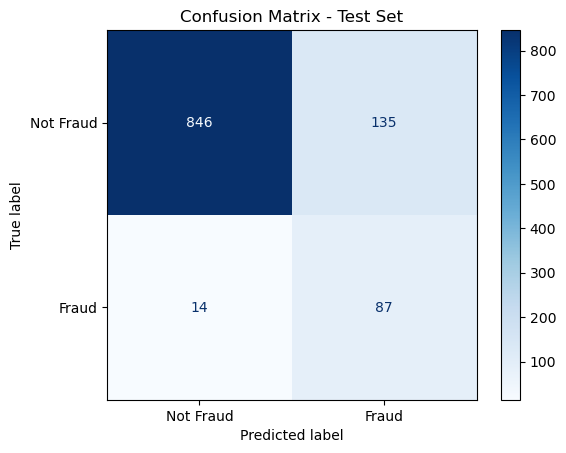

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()


In [54]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[846 135]
 [ 14  87]]


In [55]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('Confusion Matrix before manipulating by adding the threshold:\n')
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Confusion Matrix before manipulating by adding the threshold:

Accuracy: 0.86
Precision: 0.39
Recall: 0.86
F1 Score: 0.54
